<a href="https://colab.research.google.com/github/krldlamini/edm_brazildengue/blob/main/Seasonal_Surrogates%5Cnotebooks%5CSeasonal_Surrogates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Installing pyEDM

In [1]:
!pip install pyEDM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 22.5 MB/s eta 0:00:00


# Importing packages

In [2]:
from pyEDM import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Uploading and fixing data for analysis

In [4]:
file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Combined_Files/355030_A701_combined.csv'
data = pd.read_csv(file_path, delimiter = ',')
data = data.drop(columns = ['data']) # drop dates column
data = data.dropna() # dropping NA's
data_norm = (data-data.mean())/data.std() # normalising the data

# Uploading surrogate data

In [6]:
rain_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Surrogate_Data/Rain_Surrogates.csv'
tot_rain = pd.read_csv(rain_path, delimiter = ',')
max_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Surrogate_Data/MaxTemp_Surrogates.csv'
max_temp = pd.read_csv(max_path, delimiter = ',')
min_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Surrogate_Data/MinTemp_Surrogates.csv'
min_temp = pd.read_csv(min_path, delimiter = ',')

## Add Cases to the Surrogate data

Total Precipitation

In [7]:
data_norm = data_norm.reset_index(drop=True)
first_two_columns = data_norm.iloc[:, :2]
tot_rain = tot_rain.reset_index(drop=True)
surr_tot_rain = pd.concat([first_two_columns, tot_rain], axis=1)

Maximum Temperature

In [8]:
max_temp = max_temp.reset_index(drop=True)
surr_max_temp = pd.concat([first_two_columns, max_temp], axis=1)

Minimum Temperature

In [9]:
min_temp = min_temp.reset_index(drop=True)
surr_min_temp = pd.concat([first_two_columns, min_temp], axis=1)

## Perform CCM for original time series

**Maximum temperature**

In [51]:
CCM_maxtemp = CCM( dataFrame = data_norm, E = 4,
     columns = 'cases', target = 'temperatura_maxima_na_hora_ant',
     libSizes = '10 770 10', sample = 10);

In [52]:
# Extract the library size and Y:X
observed_max = CCM_maxtemp.iloc[:, :2]
observed_max.rename(columns={'cases:temperatura_maxima_na_hora_ant': 'Observed'}, inplace=True)

<ipython-input-52-bebdaa599891>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_max.rename(columns={'cases:temperatura_maxima_na_hora_ant': 'Observed'}, inplace=True)


In [53]:
c_names = surr_tot_rain.columns.tolist()[2:]

In [54]:
result_max = pd.DataFrame(observed_max)
for target in c_names:

    CCM_max_surr = CCM(dataFrame = surr_max_temp, E=4, columns='cases',
                            target= target, libSizes='10 770 10', sample=10)

    # Extract the library size and Y:X
    temp_max = CCM_max_surr.iloc[:, :2]

    # If result_max is empty, initialize it; otherwise, left merge on library size
    if result_max.empty:
        result_max = temp_max
    else:
        result_max = pd.merge(result_max, temp_max, on='LibSize', how='left')

#save results to csv
file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Surrogate_Data/'
pd.DataFrame(result_max).to_csv(file_path + 'MaxTempCCM_Surr.csv', sep =';', index=False)

**Minimum** **temperature**

In [55]:
CCM_mintemp = CCM( dataFrame = data_norm, E = 4,
     columns = 'cases', target = 'temperatura_minima_na_hora_ant',
     libSizes = '10 770 10', sample = 10)

In [56]:
# Extract the library size and Y:X
observed_min = CCM_mintemp.iloc[:, :2]
observed_min.rename(columns={'cases:temperatura_minima_na_hora_ant': 'Observed'}, inplace=True)

<ipython-input-56-3d36dc2f4f98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_min.rename(columns={'cases:temperatura_minima_na_hora_ant': 'Observed'}, inplace=True)


In [57]:
c_names = surr_tot_rain.columns.tolist()[2:]

In [58]:
result_min = pd.DataFrame(observed_min)
for target in c_names:

    CCM_min_surr = CCM(dataFrame = surr_min_temp, E=4, columns='cases',
                            target= target, libSizes='10 770 10', sample=10)

    # Extract the library size and Y:X
    temp_min = CCM_min_surr.iloc[:, :2]

    # If result_rain is empty, initialize it; otherwise, left merge on library size
    if result_min.empty:
        result_rain = temp_min
    else:
        result_min = pd.merge(result_min, temp_min, on='LibSize', how='left')

#save results to csv
file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Surrogate_Data/'
pd.DataFrame(result_min).to_csv(file_path + 'MinTempCCM_Surr.csv', sep =';', index=False)

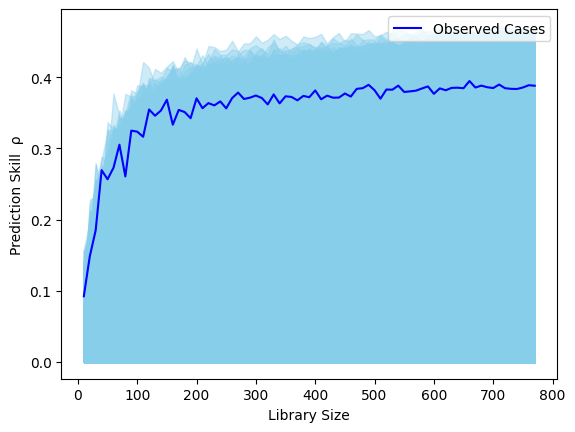

In [59]:
# Plot the first X column as a solid line
plt.plot(result_min['LibSize'], result_min['Observed'], label='Observed Cases', color='blue')

# Iterate over the rest of the X columns and shade them
for col in result_min.columns[3:]:
    plt.fill_between(result_min['LibSize'], result_min[col], color='skyblue', alpha=0.4)

plt.xlabel('Library Size')
plt.ylabel('Prediction Skill  ρ')
plt.legend()
plt.show()

**Total** **Precipitation**

CCM on observed data

In [19]:
CCM_precipitation = CCM( dataFrame = data_norm, E = 4,
     columns = 'cases', target = 'precipitacao_total_horario',
     libSizes = '10 770 10', sample = 10)



In [29]:
# Extract the library size and Y:X
observed_rain = CCM_precipitation.iloc[:, :2]
observed_rain.rename(columns={'cases:precipitacao_total_horario': 'Observed'}, inplace=True)


<ipython-input-29-5132bee0af36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_rain.rename(columns={'cases:precipitacao_total_horario': 'Observed'}, inplace=True)


CCM on surrogate time series data

In [47]:
c_names = surr_tot_rain.columns.tolist()[2:]

In [48]:
result_rain = pd.DataFrame(observed_rain)
for target in c_names:

    CCM_rain_surr = CCM(dataFrame = surr_tot_rain, E=4, columns='cases',
                            target= target, libSizes='10 770 10', sample=10)

    # Extract the library size and Y:X
    temp_rain = CCM_rain_surr.iloc[:, :2]

    # If result_rain is empty, initialize it; otherwise, left merge on library size
    if result_rain.empty:
        result_rain = temp_rain
    else:
        result_rain = pd.merge(result_rain, temp_rain, on='LibSize', how='left')


In [49]:
#save data to csv
file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Surrogate_Data/'
pd.DataFrame(result_rain).to_csv(file_path + 'RainCCM_Surr.csv', sep =';', index=False)

**Plot observed against surrogates**

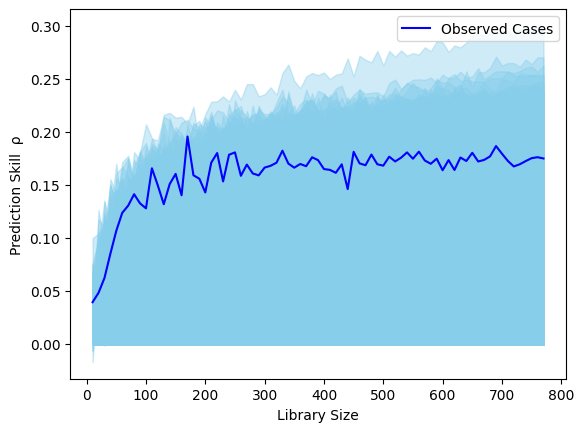

In [50]:
# Plot the first X column as a solid line
plt.plot(result_rain['LibSize'], result_rain['Observed'], label='Observed Cases', color='blue')

# Iterate over the rest of the X columns and shade them
for col in result_rain.columns[3:]:
    plt.fill_between(result_rain['LibSize'], result_rain[col], color='skyblue', alpha=0.4)

plt.xlabel('Library Size')
plt.ylabel('Prediction Skill  ρ')
plt.legend()
plt.show()